In [1]:
# https://pyimagesearch.com/2020/08/24/ocr-handwriting-recognition-with-opencv-keras-and-tensorflow/

In [2]:
# import the necessary packages
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt

In [3]:
# load the handwriting OCR model
print("[INFO] loading handwriting OCR model...")
model = load_model("G:/My Drive/Ingegneria/Data Science GD/Models/TensorFlow/MNIST/model1.h5")

[INFO] loading handwriting OCR model...


(161, 291, 3)

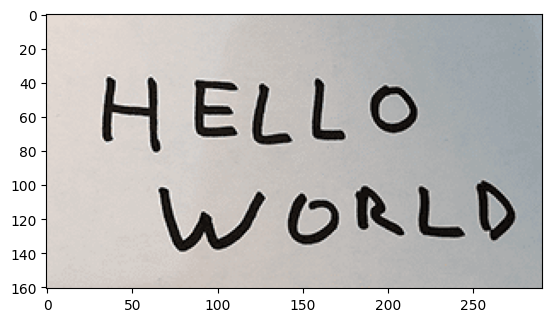

In [4]:
# load the input image from disk, convert it to grayscale, and blur it to reduce noise
image = cv2.imread("G:/My Drive/Ingegneria/Data Science GD/Models/TensorFlow/MNIST/helloworld.png")
plt.imshow(image)
image.shape

(161, 291)

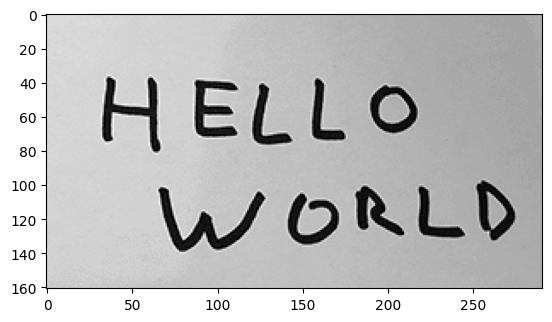

In [5]:
im_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(im_gray, cmap='gray') # otherwise the default cmap='viridis' would display the image in yellow, green and blue
im_gray.shape

(161, 291)

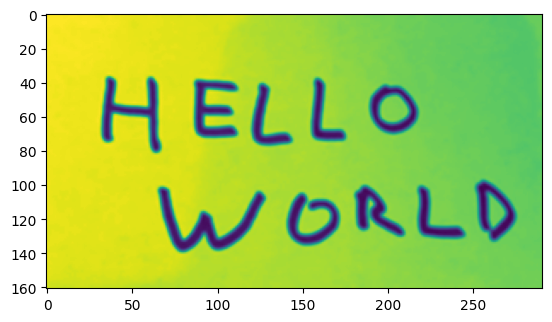

In [6]:
im_blurred = cv2.GaussianBlur(im_gray, (5, 5), 0)
plt.imshow(im_blurred)
im_blurred.shape

(161, 291)

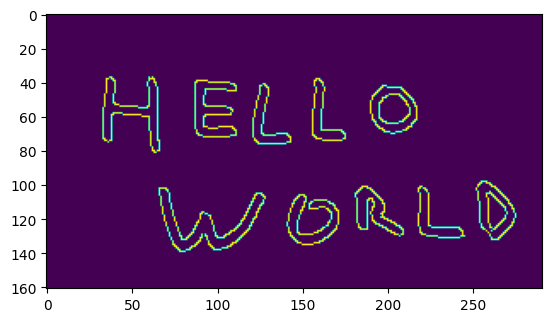

In [7]:
# perform edge detection, find contours in the edge map, and sort the resulting contours from left-to-right
im_edged = cv2.Canny(im_blurred, 30, 150)
plt.imshow(im_edged)
im_edged.shape

In [8]:
# # Perform morphological operations to enhance the characters
# kernel = np.ones((3, 3), np.uint8)
# im_dilated = cv2.dilate(im_edged, kernel, iterations=1)
# im_eroded = cv2.erode(im_dilated, kernel, iterations=1)
# plt.imshow(im_eroded)
# im_eroded.shape

In [9]:
def tupleshape_1lev(your_tuple):
    tuple_shape = []
    for arr1 in your_tuple:
        tuple_shape.append(arr1.shape)
    return tuple_shape

def tupleshape_2lev(your_tuple):
    tuple_shape = []
    for arr1 in your_tuple:
        for arr2 in arr1:
            tuple_shape.append(arr2.shape)
    return tuple_shape

In [10]:

'''
to find contours in an image. Here's a breakdown of the function call:
- edged.copy() is the input image on which you want to find contours. 
    edged is an image that has been processed to highlight edges or contours.
- cv2.RETR_EXTERNAL is the retrieval mode for contours. It specifies that you want to retrieve only the external contours, 
    ignoring any contours inside other contours.
- cv2.CHAIN_APPROX_SIMPLE is the contour approximation method. It specifies that you want to approximate the contours 
    using a simple algorithm, which compresses horizontal, vertical, and diagonal segments into their endpoints.
The cv2.findContours() function returns a tuple containing the contours found in the image and the hierarchy of the contours. 
'''

# cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
# using the above parameters, some handwritten characters united by thin lines, get wrongly processes together
# so I modify the parameters to distinguish among handwwritten characters, even if united by thin lines
cnts = cv2.findContours(im_edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
tupleshape_2lev(cnts)

# to extract the individual contours from a list of contours.
cnts_grab = imutils.grab_contours(cnts)
tupleshape_1lev(cnts_grab)

cnts_sort = sort_contours(cnts_grab, method="left-to-right")[0]
tupleshape_1lev(cnts_sort)



[(56, 1, 2),
 (242, 1, 2),
 (43, 1, 2),
 (34, 1, 2),
 (69, 1, 2),
 (27, 1, 2),
 (54, 1, 2),
 (31, 1, 2),
 (28, 1, 2),
 (35, 1, 2)]

In [11]:
def show_images(images):
    num_images = len(images)
    num_rows = (num_images + 4) // 5  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))
    fig.subplots_adjust(hspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

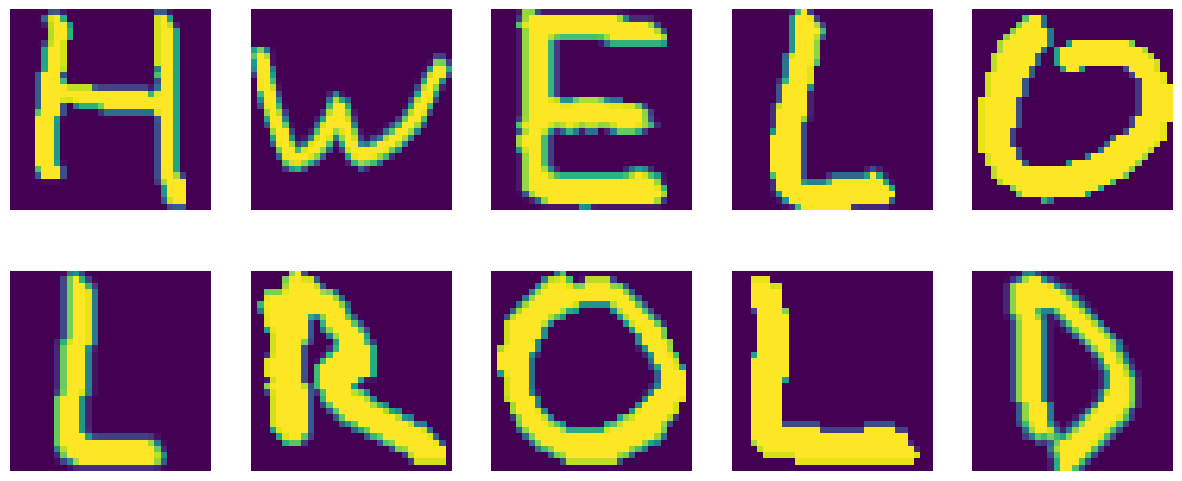

In [12]:

'''
The cv2.boundingRect(c) function is used in OpenCV (version 2) to calculate the bounding rectangle for a given contour c. 
A bounding rectangle is the smallest rectangle that can contain all the objects or points within it, without any rotation.
The contour c is a list of points that represent the outline of an object or shape in an image.
The cv2.boundingRect(c) function returns four values: (x, y, w, h). Here's what each value represents:
x: The x-coordinate of the top-left corner of the bounding rectangle.
y: The y-coordinate of the top-left corner of the bounding rectangle.
w: The width of the bounding rectangle.
h: The height of the bounding rectangle.
These values can be used to draw a rectangle around the contour c or to extract a region of interest (ROI) 
from the image that contains the contour.
'''

# initialize the list of contour bounding boxes and associated characters that we'll be OCR'ing
boxes = []
chars = []

# loop over the contours
for c in cnts_sort:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # print(x, y, w, h)
    # filter out bounding boxes, ensuring they are neither too small nor too large
    if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
    # if (w >= 1 and w <= 150) and (h >= 3 and h <= 120):
        # extract the character and threshold it to make the characterappear as *white* (foreground) on a *black* background, 
        # then grab the width and height of the thresholded image
        roi = im_gray[y:y + h, x:x + w] # region of interest
        # print(roi)
        '''
        to perform thresholding on an image region of interest (ROI) means separating relevant objects from the background
        - roi: This is the image region of interest on which the thresholding operation will be applied.
        - 0: This is the threshold value. In this case, it is set to 0, 
            which means the thresholding algorithm will determine an optimal threshold value using Otsu's method.
        - 255: This is the maximum value that will be assigned to pixels that pass the thresholding condition. 
            In this case, it is set to 255, which corresponds to white pixels.
        - cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU: These are the thresholding types. 
            cv2.THRESH_BINARY_INV specifies that the thresholding operation will be applied using the inverse binary thresholding method, 
            and cv2.THRESH_OTSU indicates that Otsu's method will be used to automatically determine the threshold value.
        - [1]: This index specifies that the thresholded image will be returned as the second element of the output tuple.
        '''
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]         
        # print(thresh)
        (tH, tW) = thresh.shape
        # print(tH, tW)
        '''
        the code below ensures that the thresh image has a consistent size of 32x32 pixels, 
        either by resizing it along the width or height dimension, depending on which dimension is larger 
        (it's done setting the largest dimension to 32, while maintaining the pic proportions)
        '''
        # if the width is greater than the height, resize along the width dimension
        if tW > tH:
            thresh = imutils.resize(thresh, width=32)
        # otherwise, resize along the height
        else:
            thresh = imutils.resize(thresh, height=32)    
        # re-grab the image dimensions (now that its been resized)
        # and then determine how much we need to pad the width and
        # height such that our image will be 32x32
        (tH, tW) = thresh.shape # new shape with maximum value of either height or width set to 32
        # print(tH, tW)
        dX = int(max(0, 32 - tW) / 2.0)
        dY = int(max(0, 32 - tH) / 2.0)
        # print(dX, dY)
        # pad the image and force 32x32 dimensions
        padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
                                    left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                                    value=(0, 0, 0))
        # print(padded.shape)
        padded = cv2.resize(padded, (32, 32))
        # print(padded.shape)
        # prepare the padded image for classification via our
        # handwriting OCR model
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)
        # print(padded.shape)
        # update our list of characters that will be OCR'd
        boxes.append((x, y, w, h))
        chars.append(padded)
    
show_images(chars)

In [13]:
# extract the bounding box locations and padded characters
boxes_extr = [b for b in boxes]
boxes

chars_extr = np.array([c for c in chars], dtype="float32")
chars_extr.shape

(10, 32, 32, 1)

In [14]:
# OCR the characters using our handwriting recognition model
preds = model.predict(chars_extr)

1/1 [==============================] - 8s 8s/step


In [15]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

[INFO] H - 99.89%
[INFO] W - 100.00%
[INFO] E - 96.97%
[INFO] L - 99.50%
[INFO] O - 49.73%
[INFO] L - 99.94%
[INFO] R - 99.54%
[INFO] O - 79.67%
[INFO] L - 99.99%
[INFO] D - 80.09%


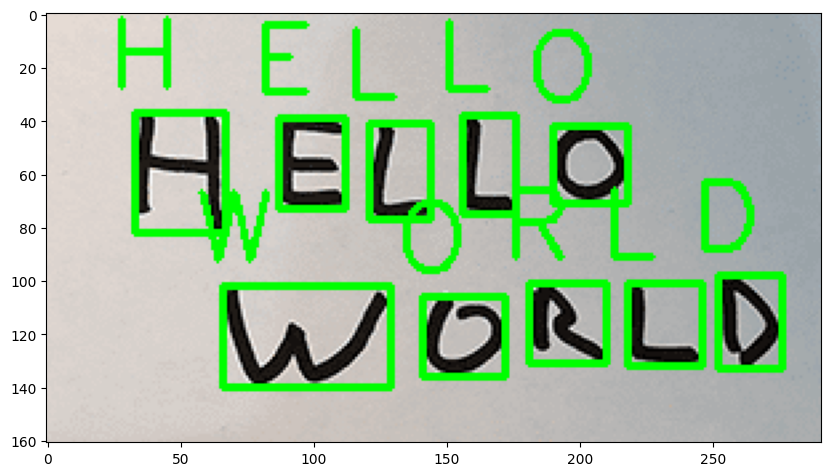

In [16]:
# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes_extr):
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]
    # draw the prediction on the image
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, label, (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    # show the image
plt.figure(figsize=(10, 8))
plt.imshow(image)